In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
image_path = '/kaggle/input/butterfly-dataset/leedsbutterfly/images'
mask_path = '/kaggle/input/butterfly-dataset/leedsbutterfly/segmentations'

In [12]:
images = os.listdir(image_path)
masks = os.listdir(mask_path)
# Display data statistics
print(f"The Data statistics\n images: {len(images)} masks: {len(masks)}")

The Data statistics
 images: 832 masks: 832


In [16]:
def get_corresponding_mask(image_name):
    base_name = image_name.split('.')[0]
    mask_name = f"{base_name}_seg0.png"
    return mask_name

In [17]:
# Display a few sample images and their corresponding masks
def show_samples(image_list, num_samples=3):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        img = Image.open(os.path.join(image_path, image_list[i]))
        mask_name = get_corresponding_mask(image_list[i])
        mask = Image.open(os.path.join(mask_path, mask_name))
        
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")
        
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(mask)
        plt.title("Mask")
        plt.axis("off")
    
    plt.show()

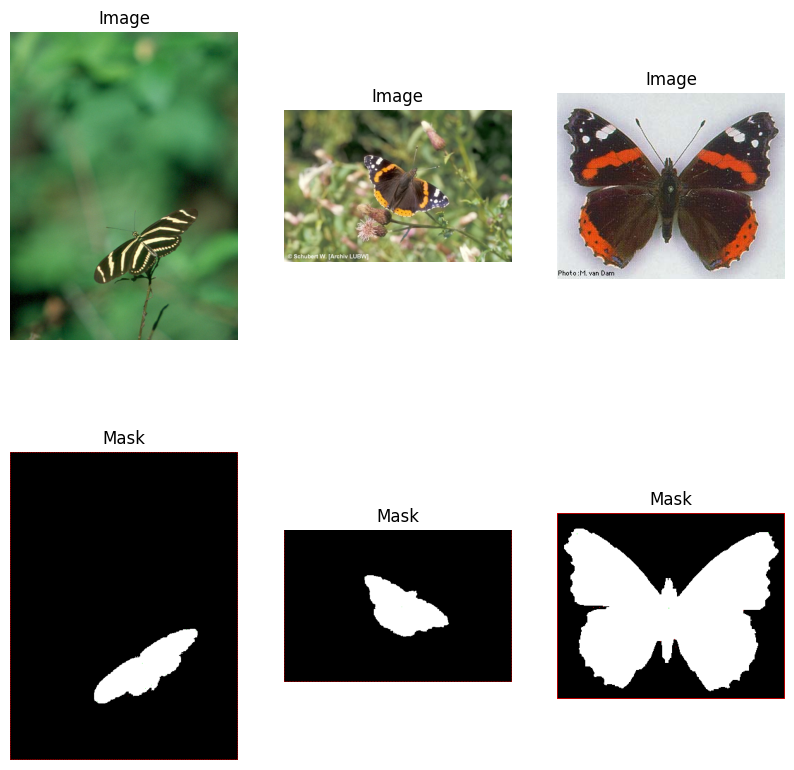

In [18]:
show_samples(images, num_samples=3)

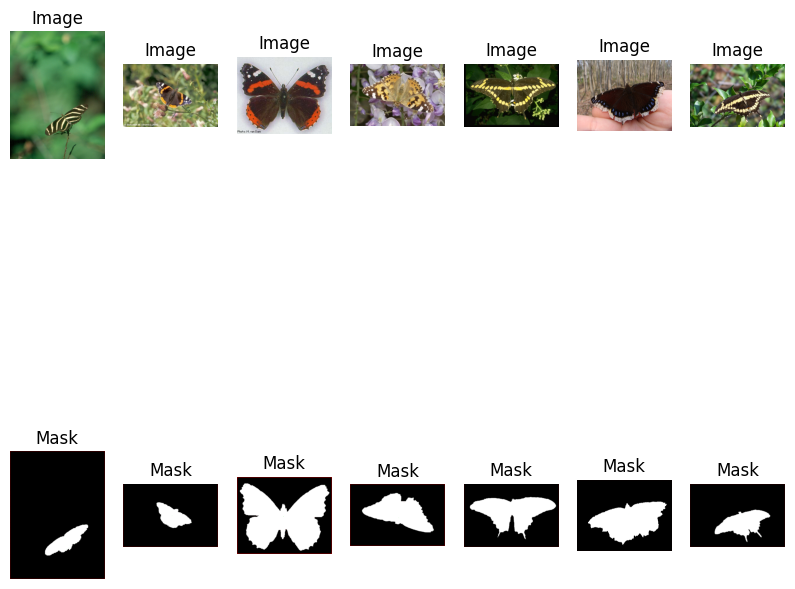

In [19]:
show_samples(images, num_samples= 7)

In [24]:
def load_data(image_dir, mask_dir, image_shape = 256):
    image_list = []
    mask_list = []

    image_names = os.listdir(image_dir)
    mask_names = [re.sub(r'\.png', '_seg0.png', name) for name in image_names]

    for img_name, mask_name in zip(image_names, mask_names):
        try:
            img = plt.imread(os.path.join(image_dir, img_name))
            mask = plt.imread(os.path.join(mask_dir, mask_name))
        except FileNotFoundError:
            print("Exception happened as the file is not found.")
            continue

        img_resized = cv2.resize(img, (image_shape, image_shape))
        mask_resized = cv2.resize(mask, (image_shape, image_shape))

        image_list.append(img_resized)
        mask_list.append(mask_resized[:, :, 0])

    return np.array(image_list), np.array(mask_list)

In [25]:
image_dir = '/kaggle/input/butterfly-dataset/leedsbutterfly/images'
mask_dir = '/kaggle/input/butterfly-dataset/leedsbutterfly/segmentations'
images, masks = load_data(image_dir, mask_dir)

In [26]:
images.shape, masks.shape

((832, 256, 256, 3), (832, 256, 256))

# Test Validation Train Split

In [27]:
X_train, X_val , y_train, y_val = train_test_split(images, masks, test_size = 0.2, random_state = 42)


In [28]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(665, 256, 256, 3) (167, 256, 256, 3) (665, 256, 256) (167, 256, 256)


In [29]:
X_train[0], y_train[0]

(array([[[5.18936276e-01, 7.52047479e-01, 3.79942685e-01],
         [5.62345684e-01, 7.80606270e-01, 4.31203276e-01],
         [6.68411076e-01, 8.78325403e-01, 5.49136996e-01],
         ...,
         [1.96273118e-01, 3.57057452e-01, 5.78233600e-02],
         [2.19239816e-01, 3.82735521e-01, 6.47974089e-02],
         [2.28370100e-01, 4.00474876e-01, 7.71675929e-02]],
 
        [[5.07382810e-01, 7.45265782e-01, 3.57068777e-01],
         [5.20916462e-01, 7.47130752e-01, 3.70118678e-01],
         [5.73132992e-01, 7.91408122e-01, 4.25978333e-01],
         ...,
         [2.23232642e-01, 3.85508597e-01, 8.60773176e-02],
         [2.42049634e-01, 4.07239228e-01, 8.89016539e-02],
         [2.43650436e-01, 4.20121014e-01, 9.72196758e-02]],
 
        [[5.04146934e-01, 7.48984516e-01, 3.57722521e-01],
         [5.04444361e-01, 7.40914106e-01, 3.49345088e-01],
         [5.11610210e-01, 7.41482198e-01, 3.47163290e-01],
         ...,
         [2.20205277e-01, 3.87079448e-01, 8.65272731e-02],
        

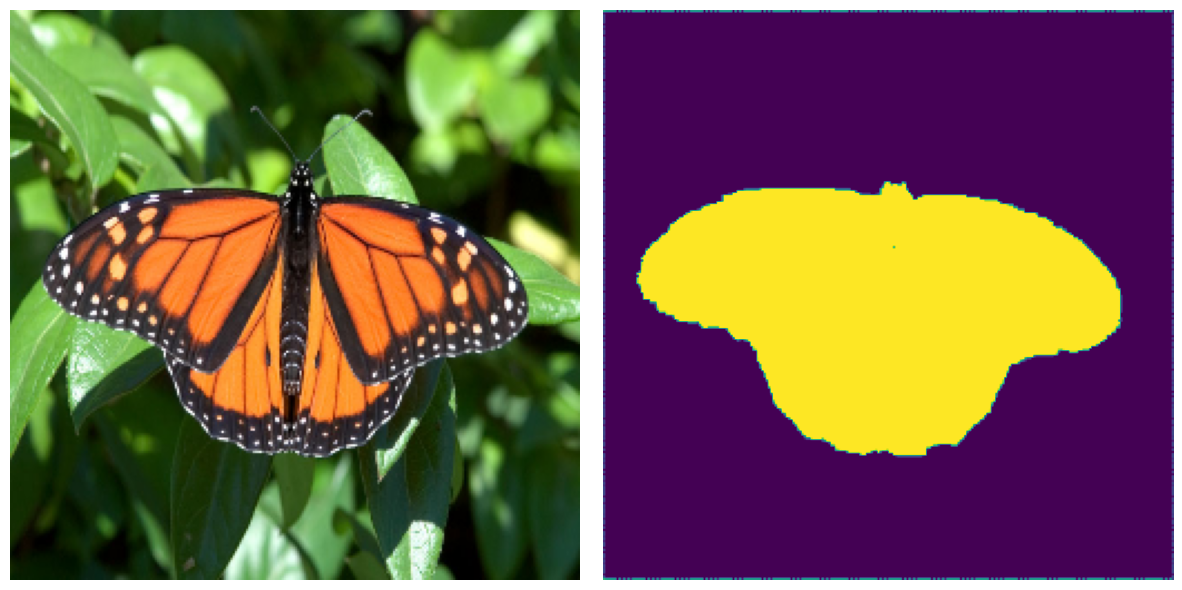

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(X_train[0])
axes[0].axis('off')   

axes[1].imshow(y_train[0])
axes[1].axis('off')  

plt.tight_layout()  
plt.show()

# Unet Architechture

In [45]:
def convolutional_block(input_tensor, num_filters, kernel_size = 3, use_batch_norm = True):
    # first convolution
    x = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),
                               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)

    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)


    #second convolution
    x = tf.keras.layers.Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),
                              kernel_initializer='he_normal', padding='same')(x)

    if use_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


In [46]:
# Function to create a U-Net model
def build_unet(input_shape, num_filters=16, dropout_rate=0.1, use_batch_norm=True):
    
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder path
    c1 = convolutional_block(inputs, num_filters * 1, use_batch_norm=use_batch_norm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(dropout_rate)(p1)

    c2 = convolutional_block(p1, num_filters * 2, use_batch_norm=use_batch_norm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(dropout_rate)(p2)

    c3 = convolutional_block(p2, num_filters * 4, use_batch_norm=use_batch_norm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(dropout_rate)(p3)

    c4 = convolutional_block(p3, num_filters * 8, use_batch_norm=use_batch_norm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(dropout_rate)(p4)

    # Bottleneck
    c5 = convolutional_block(p4, num_filters * 16, use_batch_norm=use_batch_norm)

    # Decoder path
    u6 = tf.keras.layers.Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropout_rate)(u6)
    c6 = convolutional_block(u6, num_filters * 8, use_batch_norm=use_batch_norm)

    u7 = tf.keras.layers.Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropout_rate)(u7)
    c7 = convolutional_block(u7, num_filters * 4, use_batch_norm=use_batch_norm)

    u8 = tf.keras.layers.Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropout_rate)(u8)
    c8 = convolutional_block(u8, num_filters * 2, use_batch_norm=use_batch_norm)

    u9 = tf.keras.layers.Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropout_rate)(u9)
    c9 = convolutional_block(u9, num_filters * 1, use_batch_norm=use_batch_norm)

    # Output layer
    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Model creation
    model = tf.keras.Model(inputs=[inputs], outputs=[output])
    return model


In [47]:
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate = 0.07)
unet_model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [48]:
unet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [49]:
%%capture
!pip install visualkeras

/opt/conda/lib/python3.10/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


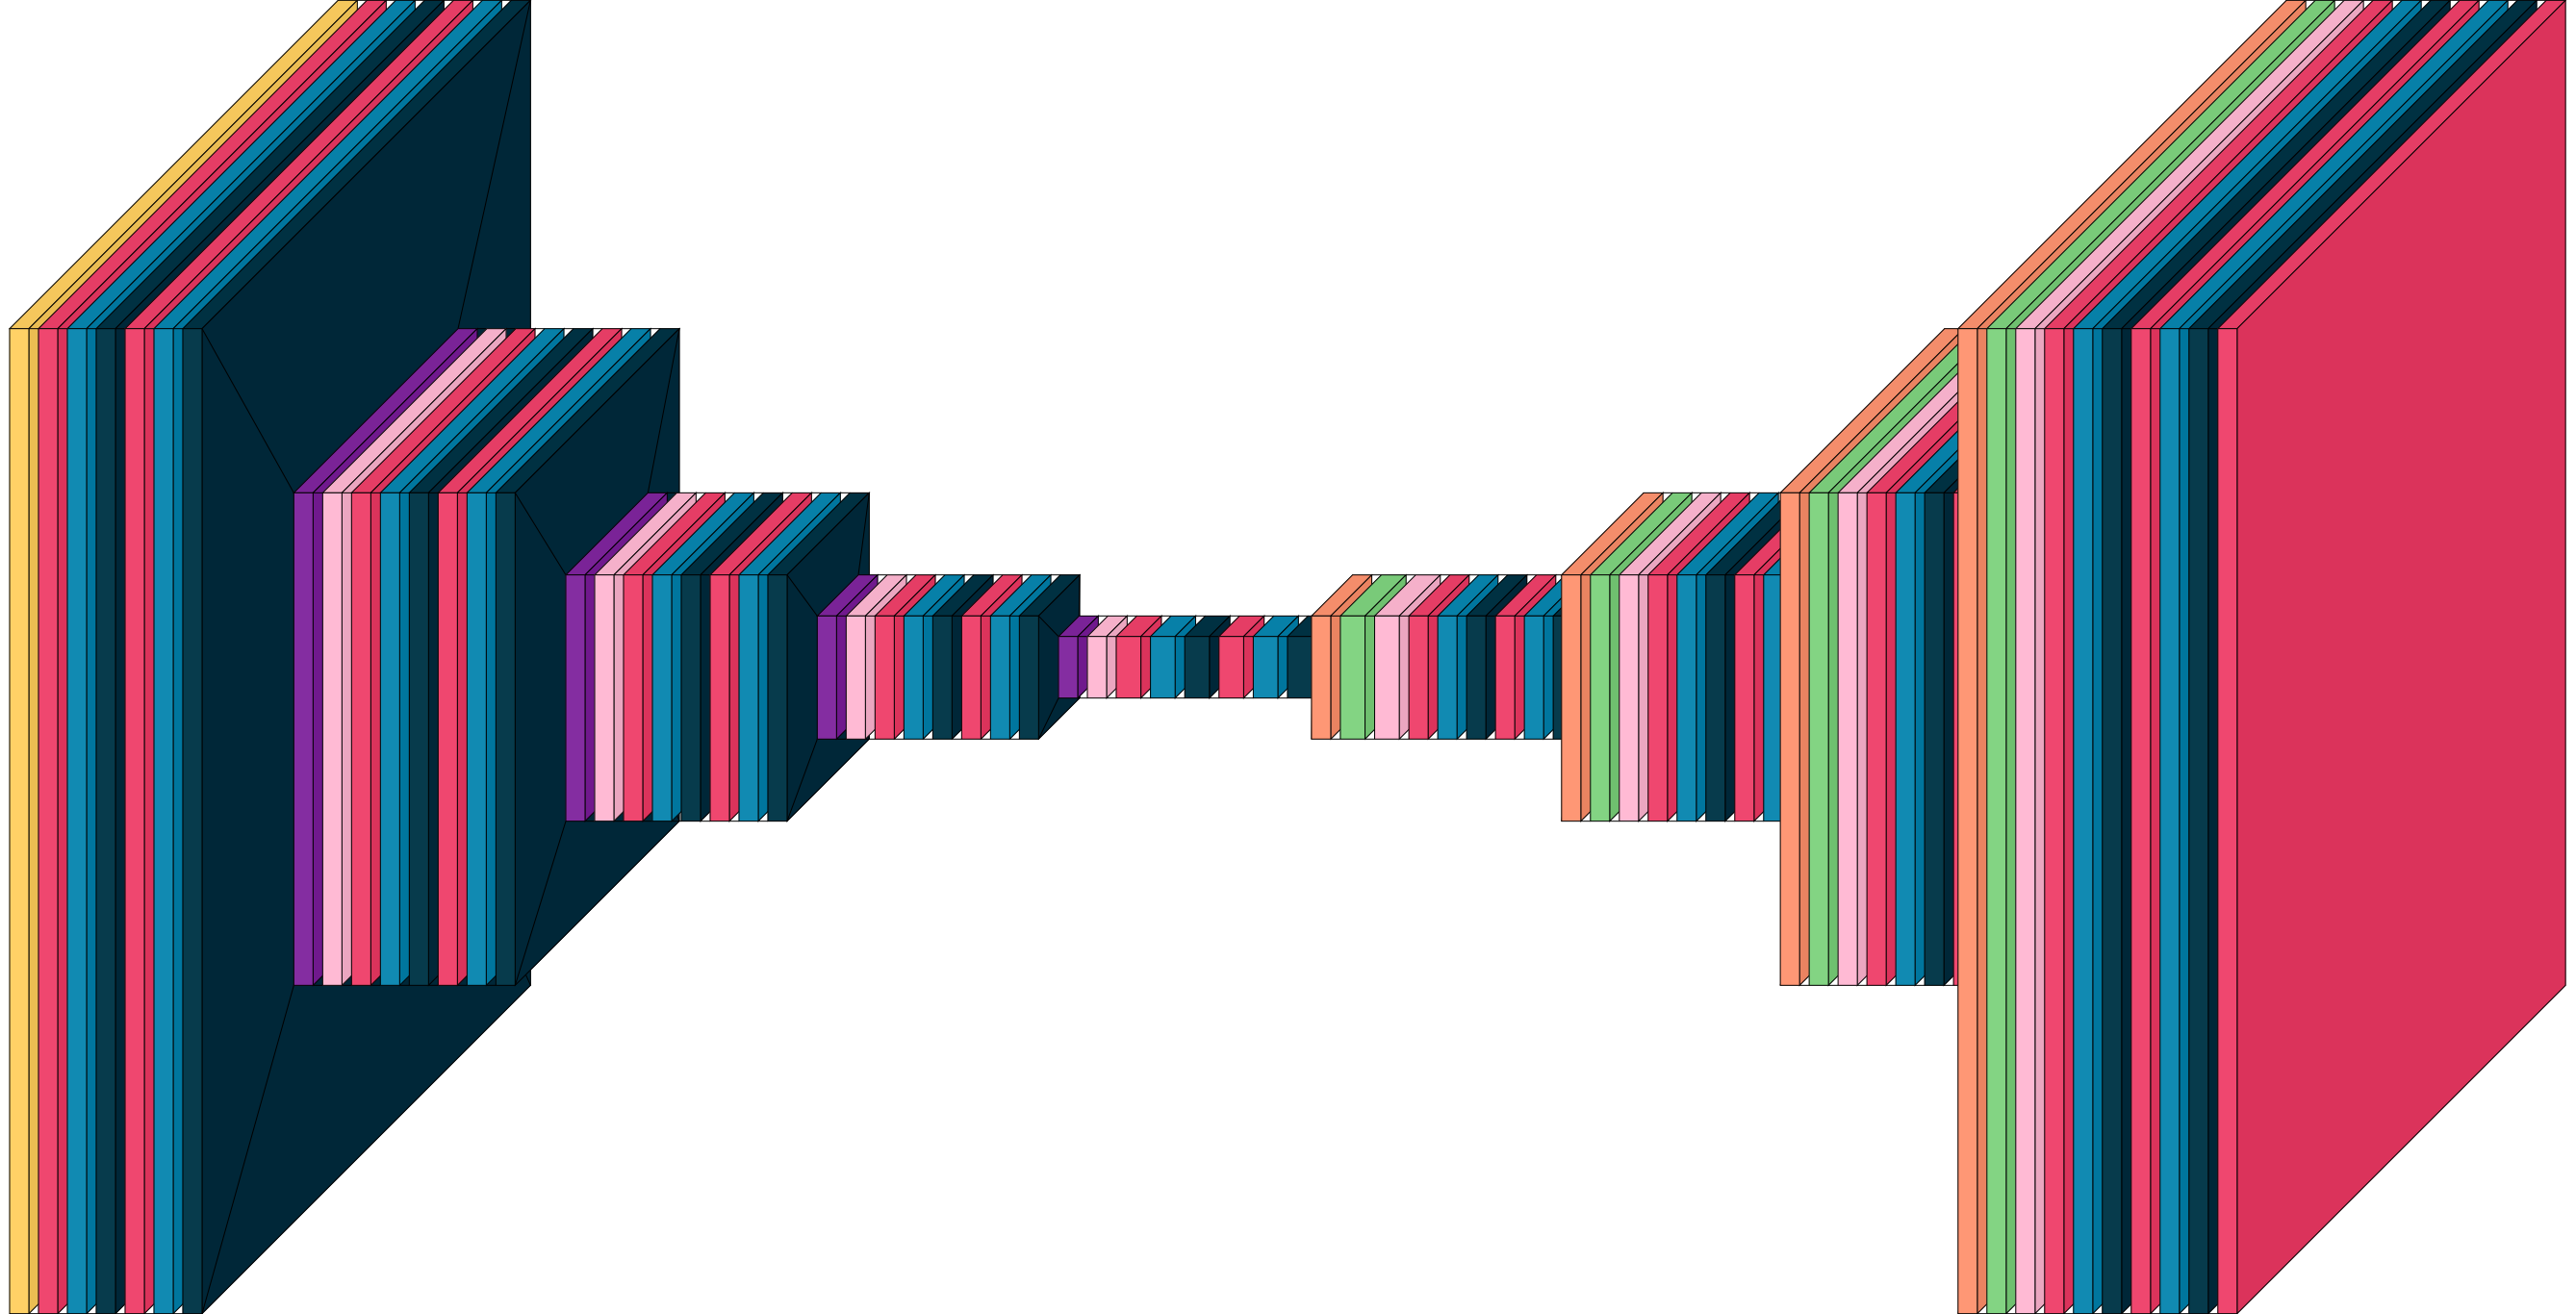

In [50]:
from visualkeras import layered_view
import visualkeras
visualkeras.layered_view(unet_model)

In [51]:
from tensorflow.keras.utils import plot_model
plot_model(unet_model, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [52]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('unet_model_best.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [53]:
# Train the model
history = unet_model.fit(X_train, 
                         y_train, 
                         validation_data=(X_val, y_val), 
                         epochs=50, 
                         verbose=1,
                         callbacks=[early_stopping, reduce_lr, model_checkpoint])

Epoch 1/50


I0000 00:00:1732049459.544673    3203 service.cc:145] XLA service 0x7c1724055d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732049459.544733    3203 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732049459.544739    3203 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732049503.785072    3203 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7369 - loss: 0.5408   
Epoch 1: val_loss improved from inf to 5.60081, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.7398 - loss: 0.5365 - val_accuracy: 0.3579 - val_loss: 5.6008 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8990 - loss: 0.2664
Epoch 2: val_loss improved from 5.60081 to 1.20138, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.8988 - loss: 0.2661 - val_accuracy: 0.7617 - val_loss: 1.2014 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9143 - loss: 0.2117
Epoch 3: val_loss did not improve from 1.20138
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step - accuracy: 0.9143 - loss: 0.2117 - val_accuracy: 0.6997 - val_loss: 2.0641 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9234 - loss: 0.1820
Epoch 4: val_loss did 

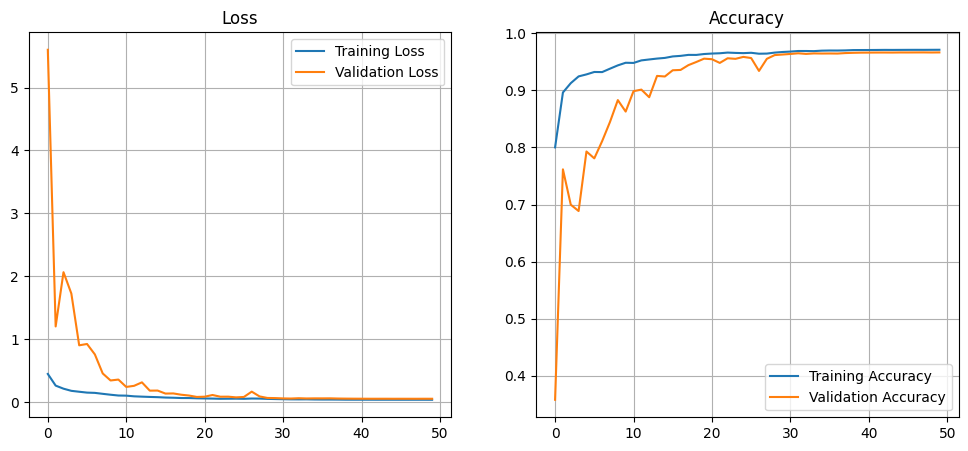

In [54]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.show()

In [55]:
# Function to predict and time the inference for a single image
def predict_single_image(image, model):
    start_time = time.time()
    prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
    end_time = time.time()
    inference_time = end_time - start_time

    return prediction, inference_time

In [56]:
# Function to visualize the prediction and ground truth
def visualize_segmentation(image, predicted_mask, ground_truth_mask):

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Inference time for a single image: 0.0568 seconds


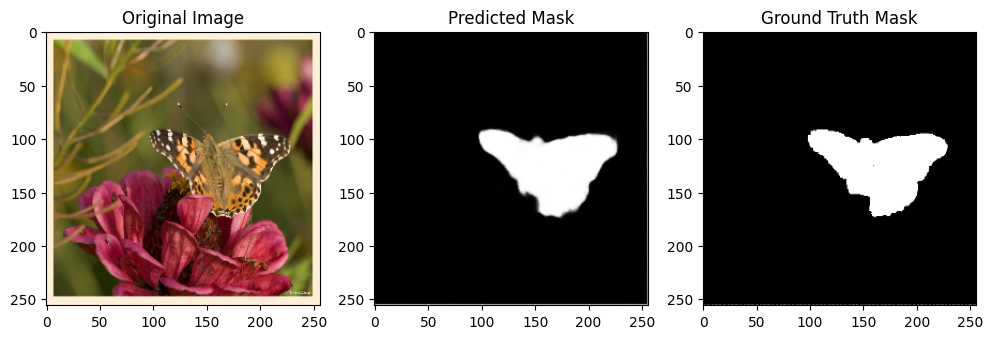

In [61]:
# Example inference on a validation image
sample_image = X_val[4]
sample_ground_truth = y_val[4]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Inference time for a single image: 0.0570 seconds


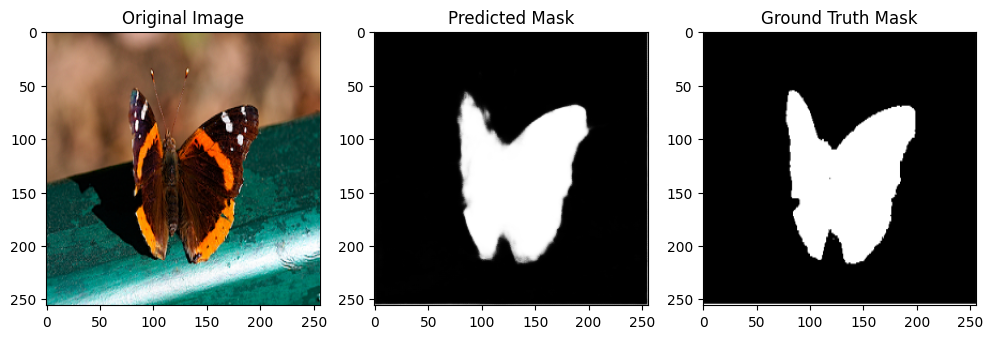

In [62]:
# Example inference on a validation image
sample_image = X_val[7]
sample_ground_truth = y_val[7]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

In [63]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred, smooth=1):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [64]:
input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate=0.07)

In [65]:
# Compile the U-Net model with Dice coefficient and mean IoU as metrics
unet_model.compile(optimizer='Adam', loss='binary_crossentropy', 
                   metrics=['accuracy', dice_coefficient, mean_iou])

In [66]:
# Train the model with the additional metrics
history = unet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.5956 - dice_coefficient: 0.4121 - loss: 0.6838 - mean_iou: 0.2611 - val_accuracy: 0.3105 - val_dice_coefficient: 0.4293 - val_loss: 5.7472 - val_mean_iou: 0.2735
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.8686 - dice_coefficient: 0.5824 - loss: 0.3761 - mean_iou: 0.4119 - val_accuracy: 0.5777 - val_dice_coefficient: 0.4689 - val_loss: 1.8102 - val_mean_iou: 0.3064
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.9024 - dice_coefficient: 0.6592 - loss: 0.2804 - mean_iou: 0.4919 - val_accuracy: 0.7353 - val_dice_coefficient: 0.5396 - val_loss: 1.9975 - val_mean_iou: 0.3700
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.9092 - dice_coefficient: 0.7055 - loss: 0.2443 - mean_iou: 0.5457 - val_accuracy: 0.6995 - val_dice_coefficient: 0.5853 - val_loss: 2.6958 - val_mean_iou: 0.4145
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 340ms/step - accuracy: 0.9195 - dice_coefficient:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


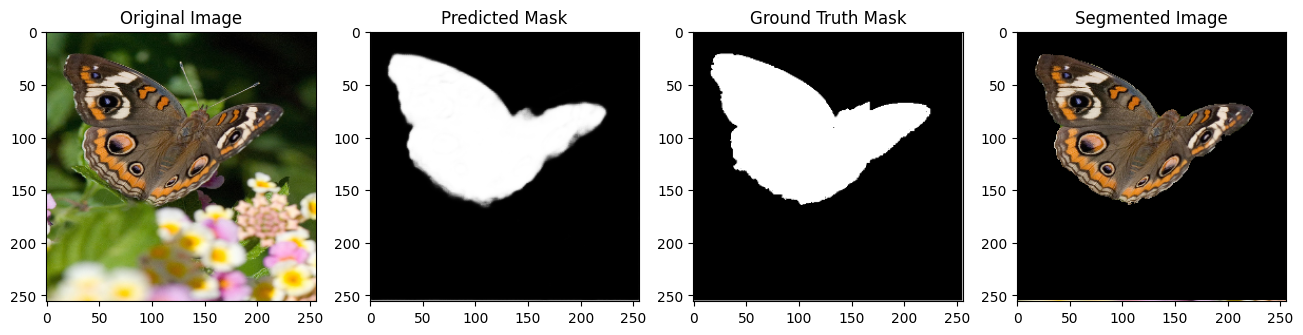

In [67]:
def visualize_segmentation_with_cropping(image, predicted_mask, ground_truth_mask):
    
    # Threshold the predicted mask to create a binary mask for segmentation
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)
    
    # Plotting the original image, predicted mask, ground truth mask, and segmented image
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')
    
    # Apply the binary mask to the original image to create the segmented output
    segmented_image = cv2.merge((binary_mask, binary_mask, binary_mask)) * image
    
    plt.subplot(1, 4, 4)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')

    plt.show()

# Example usage
sample_image = X_val[0]
sample_ground_truth = y_val[0]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


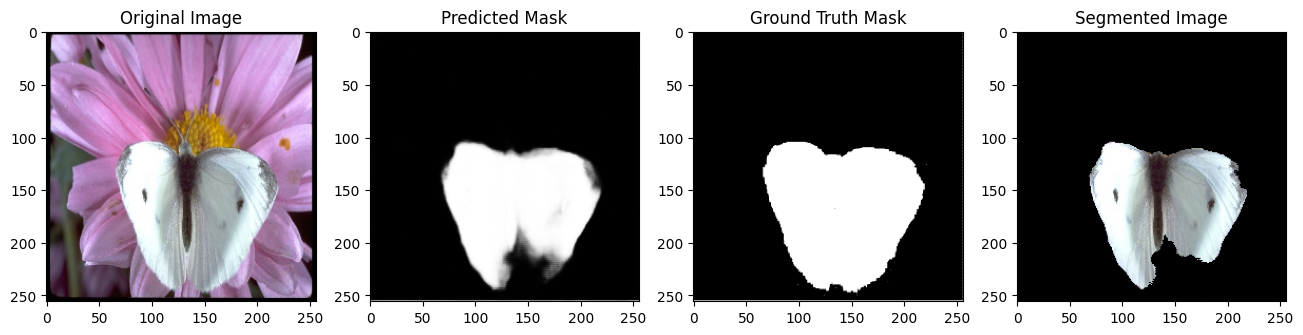

In [68]:
# Example usage
sample_image = X_val[30]
sample_ground_truth = y_val[30]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


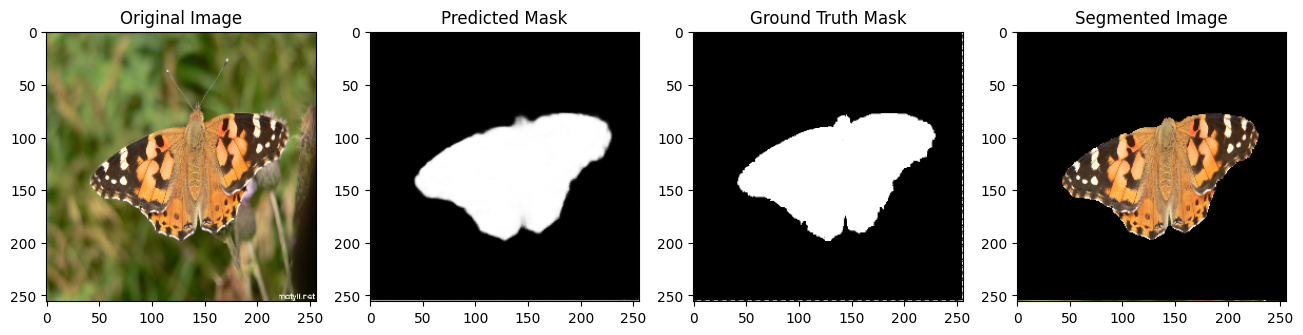

In [72]:
# Example usage
sample_image = X_val[50]
sample_ground_truth = y_val[50]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)


In [73]:
unet_model.save('final_UNET_Butterfly_Segmentation.keras')